In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os

MAX_DEPTH = 20
PROB_BRANCH = 0.25
VALUES = range(1, 10)
OPS_E = [0, 1]
OPS_T = [2, 3]
NTYPES = ['e', 't']
OP_MAP = ['+', '-', '*', '/']

In [15]:
FLANG = os.path.join('..', 'flang')
# TRAIN = os.path.join(FLANG, 'train_d30.pn1.tsv')
# VALID = os.path.join(FLANG, 'valid_d30.pn1.tsv')
# TEST = os.path.join(FLANG, 'test_d30.pn1.tsv')
TRAIN = os.path.join(FLANG, 'train_d30.pn1.more.tsv')
VALID = os.path.join(FLANG, 'valid_d30.pn1.more.tsv')
TEST = os.path.join(FLANG, 'test_d30.pn1.more.tsv')

In [16]:
def to_value_sd(sd_lst, node_lst):
    if len(sd_lst) == 0:
        node = node_lst[0]
        v = node
    else:
        i = np.argmax(sd_lst)
        child_l, v_l = to_value_sd(sd_lst[:i], node_lst[:i+1])
        child_r, v_r = to_value_sd(sd_lst[i+1:], node_lst[i+1:])
        node = [child_l, child_r]
        if isinstance(v_l, list) and not isinstance(v_r, list):
            if v_l[1] in OP_MAP:
                v1, op = v_l[0], v_l[1]
                v2 = v_r
                if op == '/':
                    v = str(int(v1) % int(v2))
#                     if v == '0':
#                         v = '1'
                else:
                    v = str(eval(''.join([v1, op, v2])) % 10)
#                     if v == '0':
#                         v = '1'
            else:
                assert v_l[0] == '('
                v = str(v_l[1])
        else:
            assert not isinstance(v_l, list) and not isinstance(v_r, list)
            v = [v_l, v_r]
            
    return node, v

In [17]:
train = []
valid = []
test = []
with open(TRAIN, 'r') as ftrain, open(VALID, 'r') as fvalid, open(TEST, 'r') as ftest:
    for line in ftrain:
        train.append(line.strip().split('\t'))
    for line in fvalid:
        valid.append(line.strip().split('\t'))
    for line in ftest:
        test.append(line.strip().split('\t'))

In [18]:
train[7]

['3 + 3 / ( 9 / 6 / 7 * 5 * 1 + 4 * 3 / 7 ) / 2 / 4',
 '1 18 1 13 11 1 2 3 4 5 6 7 8 9 10 1 2 3 4 12 14 15 16 17',
 '18']

In [19]:
node_lst, sd_lst = train[7][0].split(), list(map(int, train[7][1].split()))

In [20]:
to_value_sd(sd_lst, node_lst)

([['3', '+'],
  [[[[[['3', '/'],
       [['(',
         [[[[[[[[[['9', '/'], '6'], '/'], '7'], '*'], '5'], '*'], '1'], '+'],
          [[[['4', '*'], '3'], '/'], '7']]],
        ')']],
      '/'],
     '2'],
    '/'],
   '4']],
 '4')

In [21]:
6*9

54

In [22]:
4 % 4

0

In [23]:
val_lst = []
for node_str, ds_str, h in train:
    ds = list(map(int, ds_str.split()))
    try:
        val = to_value_sd(ds, node_str.split())[1]
        val_lst.append(int(val))
    except:
        pass

(array([ 9495., 10067.,  7645.,  8643.,  7550.,  8192.,  6509., 14437.]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 8 Patch objects>)

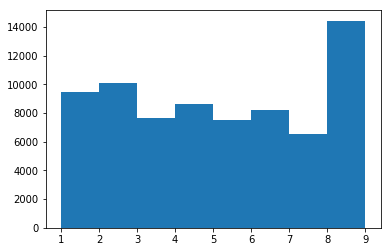

In [24]:
plt.hist(val_lst, bins=np.arange(1, 10))

In [25]:
len(val_lst)

85788

In [26]:
with open('train_d30.pn1.more.tsv', 'w') as ftrain, \
    open('valid_d30.pn1.more.tsv', 'w') as fvalid, \
    open('test_d30.pn1.more.tsv', 'w') as ftest:
    for es, f in zip([train, valid, test], [ftrain, fvalid, ftest]):
        for e in es:
            node_lst, sd_lst, h = e
            ds = list(map(int, sd_lst.split()))
            try:
                val = to_value_sd(ds, node_lst.split())[1]
                f.write('\t'.join([node_lst, sd_lst, h, val])+'\n')
            except:
                pass

# shift-reduce

In [204]:
def to_nlst(t):
    return list(filter(lambda x: x not in ['[', ']', ',', '\'', ' '], str(t)))

In [205]:
nlsts = []
sdlsts = []
trees = []
with open('train_d30.pn1.tsv', 'r') as f:
    for line in f:
        expr, ds, h, val = line.strip().split('\t')
        sdlst = list(map(int, ds.split()))
        nlst = expr.split()
        trees.append(to_value_sd(sdlst, nlst)[0])
        nlsts.append(nlst)
        sdlsts.append(sdlst)

In [206]:
str(trees[0])

"[[[[[[[['6', '/'], [['(', [[[['3', '/'], '5'], '-'], '4']], ')']], '-'], '3'], '+'], [['1', '*'], '7']], '-'], [['(', [['8', '/'], '5']], ')']]"

In [207]:
def nbrackets(t):
    return (len(list(filter(lambda x: x not in [',', '\'', ' '], str(t)))) - len(to_nlst(t)))/2

In [208]:
nbrackets(trees[100]), len(to_nlst(trees[100]))

(4.0, 5)

In [209]:
''.join(nlsts[0])

'6/(3/5-4)-3+1*7-(8/5)'

In [210]:
sdlsts[0]

[1, 7, 5, 1, 2, 3, 4, 6, 8, 9, 10, 11, 1, 2, 12, 13, 3, 1, 2, 4]

In [211]:
def combine(a0, a1):
    def unfinised(n):
        return isinstance(n, list) or isinstance(n, tuple)
    
    if unfinised(a0):
        if a1 == ')':
            lp, num = a0
            assert lp == '('
            return num
        else:
            num, op = a0
            return eval(''.join([str(num),op,str(a1)]))
    else:
        return (a0, a1)      

In [212]:
def shift_reduce(nlst, sdlst):
    N = 0
    mem = []
    mem.append((nlst[0],  sdlst[0]))

    for n, sd in zip(nlst[1:], sdlst[1:]+[10000]):
        mem.append((n, sd))
        while mem[-1][1] > mem[-2][1]:
            a1, sd1 = mem.pop()
            a0, sd0 = mem.pop()
            res = combine(a0, a1)
#             print(a0, a1, res)
            mem.append((res, sd1))
            if len(mem) == 1:
                break
                
    assert len(mem) == 1
    return float(mem[0][0])

In [356]:
# simplified
def shift_reduce(nlst, sdlst):
    N = 0
    mem = []
    mem.append((nlst[0],  sdlst[0]))

    for n, sd in zip(nlst[1:], sdlst[1:]+[10000]):
        while sd > mem[-1][1]:
            a0, sd0 = mem.pop()
            n = combine(a0, n)
            if len(mem) == 0:
                break
        mem.append((n, sd))
                
    assert len(mem) == 1
    return float(mem[0][0])

In [218]:
shift_reduce(nlsts[0], sdlsts[0])

0.6352941176470588

In [219]:
eval('6/(3/5-4)-3+1*7-(8/5)')

0.6352941176470588

In [220]:
shift_reduce(['(', '3', ')'], [1, 2])

3.0

In [221]:
for nlst, sdlst in zip(nlsts,sdlsts):
    try:
        eval(''.join(nlst))
    except:
        continue
    
    if shift_reduce(nlst, sdlst) != eval(''.join(nlst)):
        print(nlst, sdlst)
        print(eval(''.join(nlst)))

In [153]:
a = [1,2,3,4]

In [110]:
a[-1]

4

In [111]:
a[-2]

3

In [103]:
def plot_sd(nlst, sd_lst):
    fig, ax = plt.subplots()
    fig.dpi = 200
    plt.bar(np.arange(len(sd_lst)), sd_lst)
    plt.xticks(np.arange(len(nlst))-0.5, nlst)
    plt.grid(axis='y', linestyle='--')

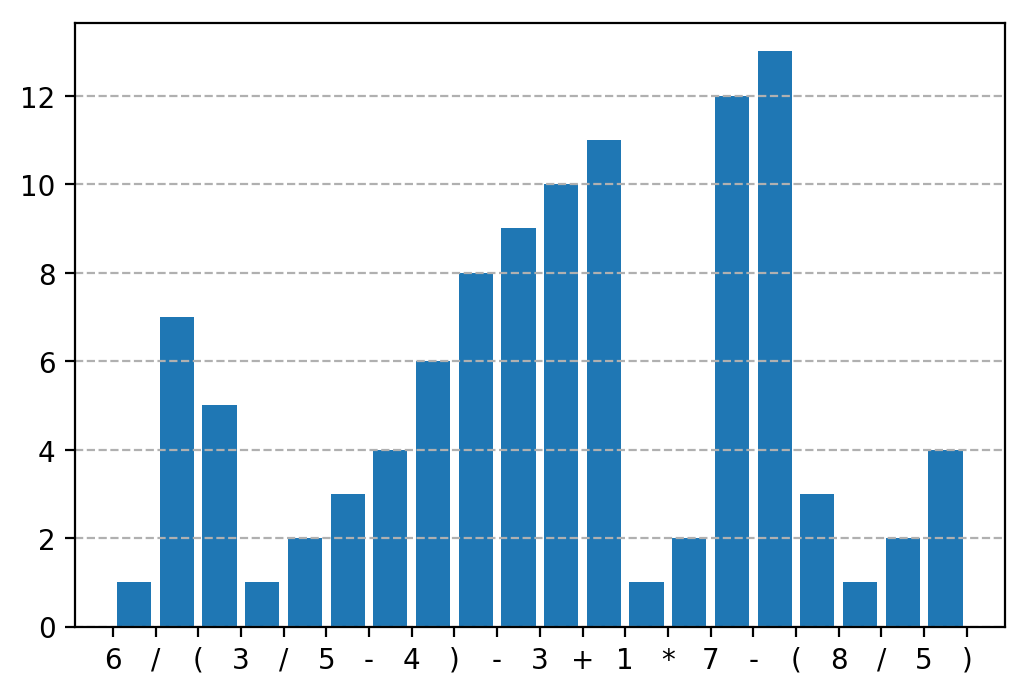

In [104]:
plot_sd(nlsts[0], sdlsts[0])

# shift-reduce-bracket

In [201]:
def to_str(t):
    return list(filter(lambda x: x not in [',', '\'', ' '], str(t)))

In [203]:
''.join(to_str(trees[0]))

'[[[[[[[[6/][[([[[[3/]5]-]4]])]]-]3]+][[1*]7]]-][[([[8/]5]])]]'

In [233]:
sdlsts[0]

[1, 7, 5, 1, 2, 3, 4, 6, 8, 9, 10, 11, 1, 2, 12, 13, 3, 1, 2, 4]

In [235]:
''.join(nlsts[0])

'6/(3/5-4)-3+1*7-(8/5)'

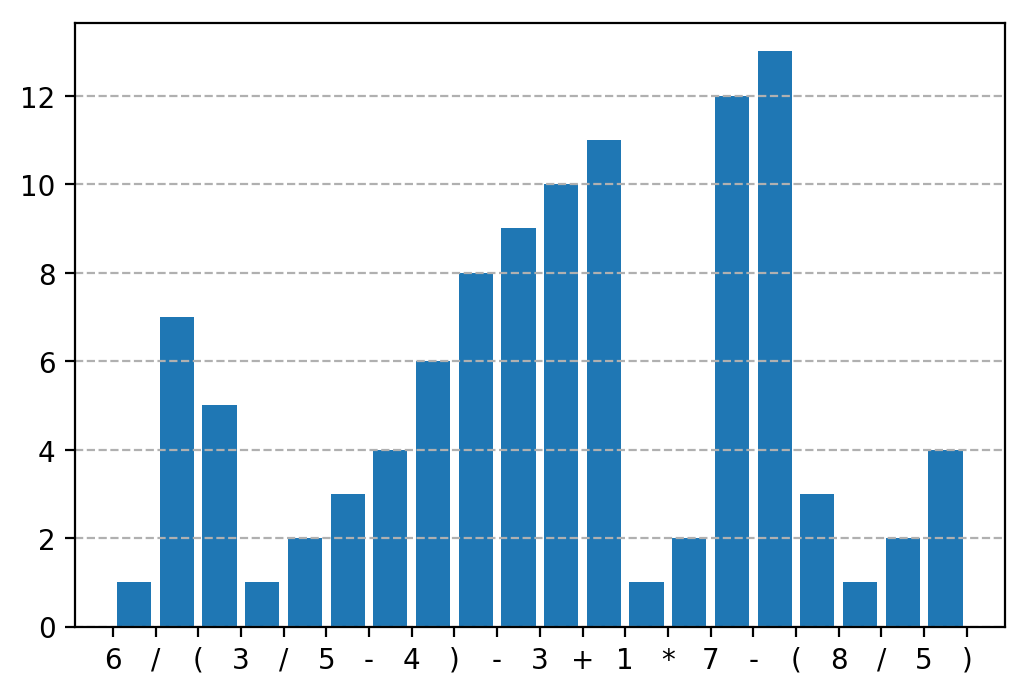

In [236]:
plot_sd(nlsts[0], sdlsts[0])

一个节点处左右两个句法距离若为从左至右增，则要在这个节点后加一个右括号;
且子树合并看成一个节点（如这里的3/5-4），若这个节点左右两边句法距离增，也要加一个右括号

加右括号的增量算法：从左至右，每一个句法距离找其第一个比其大的，在那个柱右端点处加括号

In [252]:
a = [1,2,3]
# a.insert(3,1)
# print(a)

In [253]:
list(range(len(a), 0, -1))

[3, 2, 1]

In [241]:
for i, v in enumerate(reversed([1,2,3])):
    print(i,v)

0 3
1 2
2 1


In [257]:
nlst0 = list(nlsts[0])
sdlst0 = list(sdlsts[0])

In [258]:
add_rbracktets(nlst0, sdlst0)

In [260]:
''.join(nlst0)

'6/](3/]5]-]4])]-]3]+]1*]7]-](8/]5])]'

In [261]:
''.join(nlsts[0])

'6/(3/5-4)-3+1*7-(8/5)'

In [ ]:
plt.bar(range())

In [ ]:
def shift_reduce(nlst, sdlst):
    N = 0
    mem = []
    mem.append((nlst[0],  sdlst[0]))

    for n, sd in zip(nlst[1:], sdlst[1:]+[10000]):
        while sd > mem[-1][1]:
            a0, sd0 = mem.pop()
            n = combine(a0, n)
            if len(mem) == 0:
                break
        mem.append((n, sd))
                
    assert len(mem) == 1
    return float(mem[0][0])

In [226]:
def shift_reduce_btstr(btstr):
    N = 0
    mem = []
    depth = 0

    for n in btstr:
        if n == '[':
            pass
        elif n == ']':
            n1 = mem.pop()
            n0 = mem.pop()
            res = combine(n0, n1)
            mem.append(res)
        else:
            mem.append(n)
                
    assert len(mem) == 1
    return float(mem[0])

In [228]:
shift_reduce_btstr(to_str(trees[0]))

0.6352941176470588

In [232]:
for t in trees:
    btstr = to_str(t)
    try:
        eval(''.join(to_nlst(t)))
    except:
        continue
        
    if shift_reduce_btstr(btstr) != eval(''.join(to_nlst(t))):
        print(t)

# add right brackets guided by sdlist

In [348]:
def add_rbrackets(nlst, sdlst):
    nlst = list(nlst)
    pnts = []
    sdlst = list(sdlst)+[1000]
    for i, sd_i in enumerate(sdlst):
#         print(sd_i)
        for j, sd_j in enumerate(sdlst[i+1:]):
            if sd_j > sd_i:
#                 print(i, i+j+1, sd_i, sd_j)
                pnts.append(i+j+2)
                break
    pnts = sorted(pnts)
    for pnt in reversed(pnts):
        nlst.insert(pnt, ']')
    
    return nlst

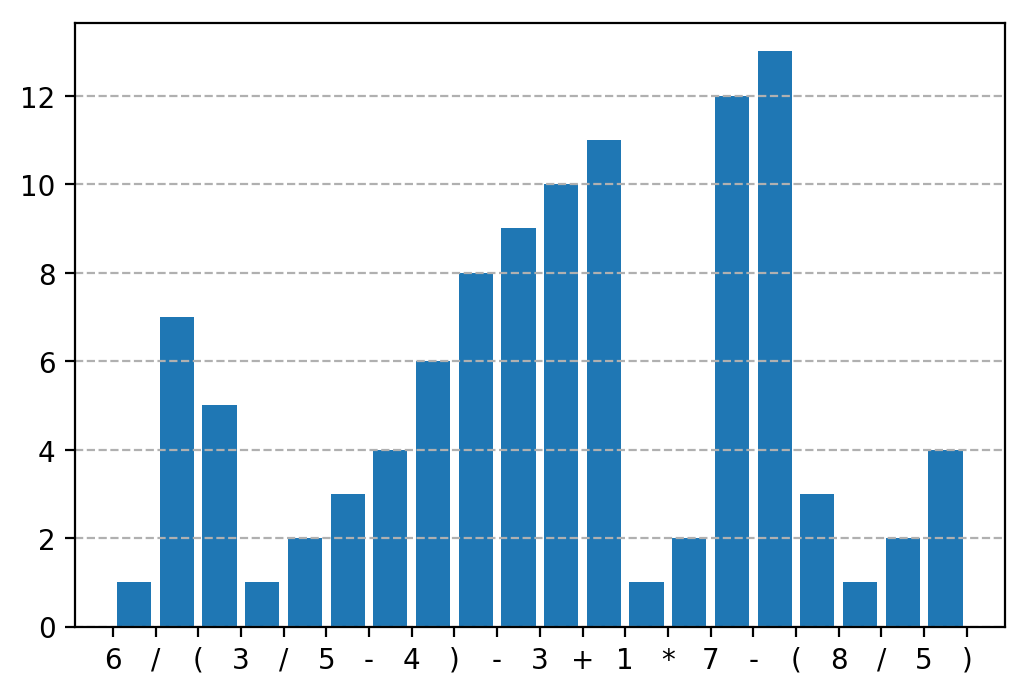

In [329]:
plot_sd(nlsts[0], sdlsts[0])

In [349]:
''.join(add_rbrackets(nlsts[0], sdlsts[0]))

'6/](3/]5]-]4]])]]-]3]+]1*]7]]-](8/]5]])]]'

In [318]:
''.join(nlsts[0])

'6/(3/5-4)-3+1*7-(8/5)'

In [316]:
len(''.join(nlsts[0])

21

In [307]:
def to_rbstr(t):
    return list(filter(lambda x: x not in ['[', ',', '\'', ' '], str(t)))

In [275]:
''.join(to_rbstr(trees[0]))

'6/](3/]5]-]4]])]]-]3]+]1*]7]]-](8/]5]])]]'

In [276]:
''.join(to_str(trees[0]))

'[[[[[[[[6/][[([[[[3/]5]-]4]])]]-]3]+][[1*]7]]-][[([[8/]5]])]]'

In [350]:
shift_reduce_btstr(add_rbrackets(nlsts[0], sdlsts[0]))

0.6352941176470588

In [355]:
for nlst, sdlst in zip(nlsts, sdlsts):
#     print(nlst, sdlst)
    rbstr = add_rbrackets(nlst, sdlst)
    try:
        eval(''.join(nlst))
    except:
        continue
    
    
    if shift_reduce_btstr(rbstr) != eval(''.join(nlst)):
        print(rbstr)

# which needs brackets indeed

In [185]:
def remove_brackets(expr):
    return ''.join(list(filter(lambda x: x not in ['(',')'], expr)))

In [188]:
test_easy = []
test_hard = []
for line in test:
    expr, ds, h  = line
    try:
        is_easy = eval(remove_brackets(expr)) == eval(expr)
    except:
        continue
        
    if is_easy:
        test_easy.append((expr, ds, h))
    else:
        test_hard.append((expr, ds, h))

In [189]:
len(test_easy)

7523

In [190]:
len(test_hard)

2444

In [194]:
es = test_easy
with open('test_d30.pn1.easy.tsv', 'w') as f:
    for e in es:
        node_lst, sd_lst, h = e
        ds = list(map(int, sd_lst.split()))
        try:
            val = to_value_sd(ds, node_lst.split())[1]
            f.write('\t'.join([node_lst, sd_lst, h, val])+'\n')
        except:
            pass

In [195]:
es = test_hard
with open('test_d30.pn1.hard.tsv', 'w') as f:
    for e in es:
        node_lst, sd_lst, h = e
        ds = list(map(int, sd_lst.split()))
        try:
            val = to_value_sd(ds, node_lst.split())[1]
            f.write('\t'.join([node_lst, sd_lst, h, val])+'\n')
        except:
            pass